In [1]:
from datetime import datetime
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch
from dotenv import load_dotenv
from fitz_utils import ProcessedDoc
from PIL import Image
from tqdm import tqdm
from transformers import AutoConfig, AutoModelForCausalLM, AutoProcessor
load_dotenv()
from models.modeling_florence2 import Florence2ForConditionalGeneration
from models.processing_florence2 import Florence2Processor
device = torch.device("cuda")


/home/saeed/mambaforge/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/saeed/mambaforge/envs/thesis/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
from models.modeling_florence2 import Florence2ForConditionalGeneration, Florence2Config

In [3]:
config = Florence2Config.from_pretrained("/home/saeed/florence2-training/models/config.json")

In [4]:
model = Florence2ForConditionalGeneration.from_pretrained("/home/saeed/florence2-training/models/model.safetensors", config=config)

/home/saeed/florence2-training/models/Wordnn_embedding.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  word_embs = torch.load(bros_embedding_path, map_location="cpu")


use_pretrain_weight: load model from: /home/saeed/florence2-training/models/word_embeddings.pt


Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of Florence2ForConditionalGeneration were not initialized from the model checkpoint at /home/saeed/florence2-training/models/

In [5]:
import torch

In [13]:
def quant_bbox(width, height, boxes, category_ids):
    bins_w, bins_h = [1000, 1000]  # Quantization bins.
    size_per_bin_w = width / bins_w
    size_per_bin_h = height / bins_h

    bbox_str_dict = {cat_id: id2label[cat_id] for cat_id in category_ids}
    for bbox, cat_id in zip(boxes, category_ids):
        bbox = bbox.copy()

        xmin, ymin, xmax, ymax = torch.tensor(bbox).split(1, dim=-1)
        quantized_xmin = (xmin / size_per_bin_w).floor().clamp(0, bins_w - 1)
        quantized_ymin = (ymin / size_per_bin_h).floor().clamp(0, bins_h - 1)
        quantized_xmax = (xmax / size_per_bin_w).floor().clamp(0, bins_w - 1)
        quantized_ymax = (ymax / size_per_bin_h).floor().clamp(0, bins_h - 1)

        quantized_boxes = torch.cat(
            (quantized_xmin, quantized_ymin, quantized_xmax, quantized_ymax), dim=-1
        ).int()

        bbox_str_dict[cat_id] += (
            f"<loc_{quantized_boxes[0]}><loc_{quantized_boxes[1]}><loc_{quantized_boxes[2]}><loc_{quantized_boxes[3]}>"
        )

    full_bbox_str = ""
    class_strs = []
    for bbox_str in bbox_str_dict.values():
        full_bbox_str += bbox_str
        class_strs.append(bbox_str)
    return full_bbox_str, class_strs

In [9]:
data_root = "/media/saeed/cb770179-4e9f-49f3-b105-5be4357ac72e/Doclaynet/FullData"
from pycocotools.coco import COCO
import os 
images_path = os.path.join(data_root, "val", "images")
coco_path = os.path.join(data_root, "COCO", "val.json")

In [10]:
coco = COCO(coco_path)
all_imge_ids = coco.getImgIds()

loading annotations into memory...
Done (t=0.80s)
creating index...
index created!


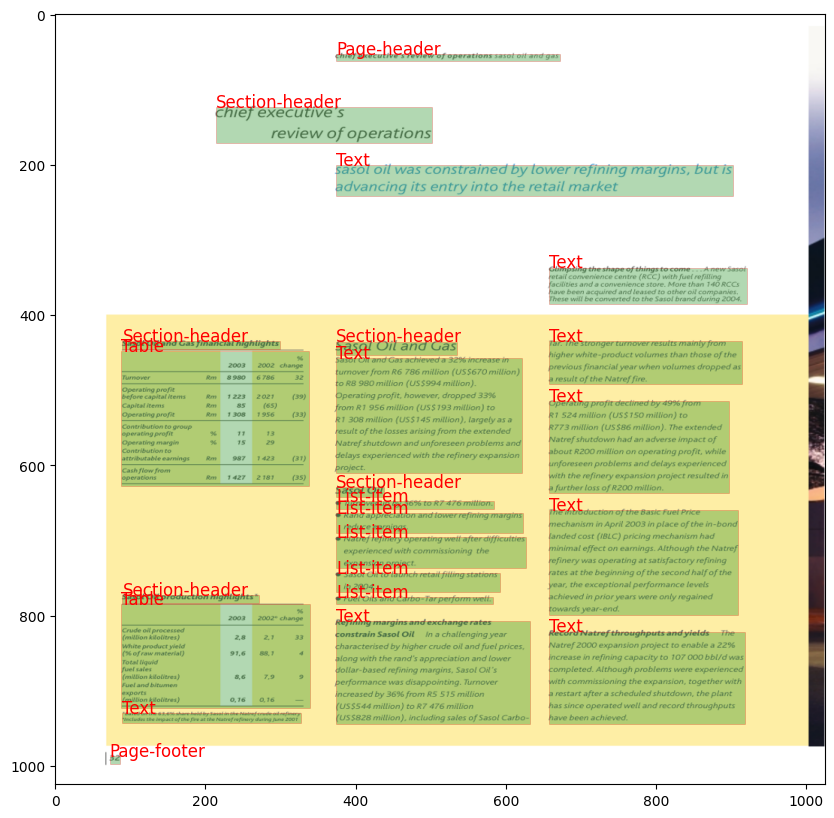

In [35]:
all_images_info = coco.loadImgs(all_imge_ids)
import random
from PIL import Image
random_image = random.choice(all_images_info)
file_name = random_image["file_name"]
image_id = random_image["id"]
image_path = os.path.join(images_path, file_name)
annotations = coco.loadAnns(coco.getAnnIds(image_id))
id2label = coco.cats
image = Image.open(image_path)
import matplotlib.pyplot as plt
import numpy as np
def plot_bounding_boxes(image,anno,figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    for ann in anno:
        box = ann['bbox']
        rect = plt.Rectangle((box[0], box[1]), box[2], box[3], linewidth=0.5, edgecolor='r', facecolor='g',alpha=0.3)
        #add class name
        ax.text(box[0], box[1], id2label[ann['category_id']]['name'], fontsize=12, color='red')
        ax.add_patch(rect)
    plt.show()
plot_bounding_boxes(image,annotations)

In [30]:
id2label

{1: {'supercategory': 'Caption', 'id': 1, 'name': 'Caption'},
 2: {'supercategory': 'Footnote', 'id': 2, 'name': 'Footnote'},
 3: {'supercategory': 'Formula', 'id': 3, 'name': 'Formula'},
 4: {'supercategory': 'List-item', 'id': 4, 'name': 'List-item'},
 5: {'supercategory': 'Page-footer', 'id': 5, 'name': 'Page-footer'},
 6: {'supercategory': 'Page-header', 'id': 6, 'name': 'Page-header'},
 7: {'supercategory': 'Picture', 'id': 7, 'name': 'Picture'},
 8: {'supercategory': 'Section-header', 'id': 8, 'name': 'Section-header'},
 9: {'supercategory': 'Table', 'id': 9, 'name': 'Table'},
 10: {'supercategory': 'Text', 'id': 10, 'name': 'Text'},
 11: {'supercategory': 'Title', 'id': 11, 'name': 'Title'}}

In [12]:
first_image_annotations = coco.loadAnns(coco.getAnnIds(imgIds=all_imge_ids[0]))
first_image = coco.loadImgs(all_imge_ids[0])[0]

In [22]:
cat_ids = [ann["category_id"] for ann in first_image_annotations]
boxes = [ann["bbox"] for ann in first_image_annotations]

In [8]:
id2label = {
    1: "Caption",
    2: "Footnote",
    3: "Formula",
    4: "ListItem",
    5: "PageFooter",
    6: "PageHeader",
    7: "Picture",
    8: "SectionHeader",
    9: "Table",
    10: "Text",
    11: "Title",
}

In [27]:
a=  quant_bbox(first_image["width"], first_image["height"], boxes, cat_ids)

In [28]:
a

('Caption<loc_204><loc_30><loc_169><loc_38>Picture<loc_424><loc_0><loc_575><loc_575>SectionHeader<loc_65><loc_109><loc_283><loc_13>Text<loc_65><loc_130><loc_317><loc_128><loc_65><loc_266><loc_317><loc_128><loc_65><loc_404><loc_317><loc_78><loc_109><loc_611><loc_842><loc_303>PageFooter<loc_17><loc_980><loc_7><loc_10>',
 ['Caption<loc_204><loc_30><loc_169><loc_38>',
  'Picture<loc_424><loc_0><loc_575><loc_575>',
  'SectionHeader<loc_65><loc_109><loc_283><loc_13>',
  'Text<loc_65><loc_130><loc_317><loc_128><loc_65><loc_266><loc_317><loc_128><loc_65><loc_404><loc_317><loc_78><loc_109><loc_611><loc_842><loc_303>',
  'PageFooter<loc_17><loc_980><loc_7><loc_10>'])

In [29]:
pickles_path = os.path.join(data_root, 'word_pickles')
files = os.listdir(pickles_path)
f = files[0]
import pickle
with open(os.path.join(pickles_path, f), 'rb') as file:
    data = pickle.load(file)


In [31]:
data.keys()

dict_keys(['input_ids', 'bbox_subword_list', 'texts', 'bbox_texts_list'])

In [1]:
from generate_dataset import *

/home/saeed/mambaforge/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NUM_BATCHES 8


In [2]:
data = COCODataset(base_dir/"COCO/test.json", base_dir/"test/images", base_dir/"word_pickles")

/media/saeed/cb770179-4e9f-49f3-b105-5be4357ac72e/Doclaynet/FullData/COCO
loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


In [1]:
from datasets import load_dataset, load_from_disk
# Load the dataset from disk
dataset  = load_from_disk("/home/docanalysis/florence2-training/dataset_florence2_td/test")

/home/docanalysis/mambaforge/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


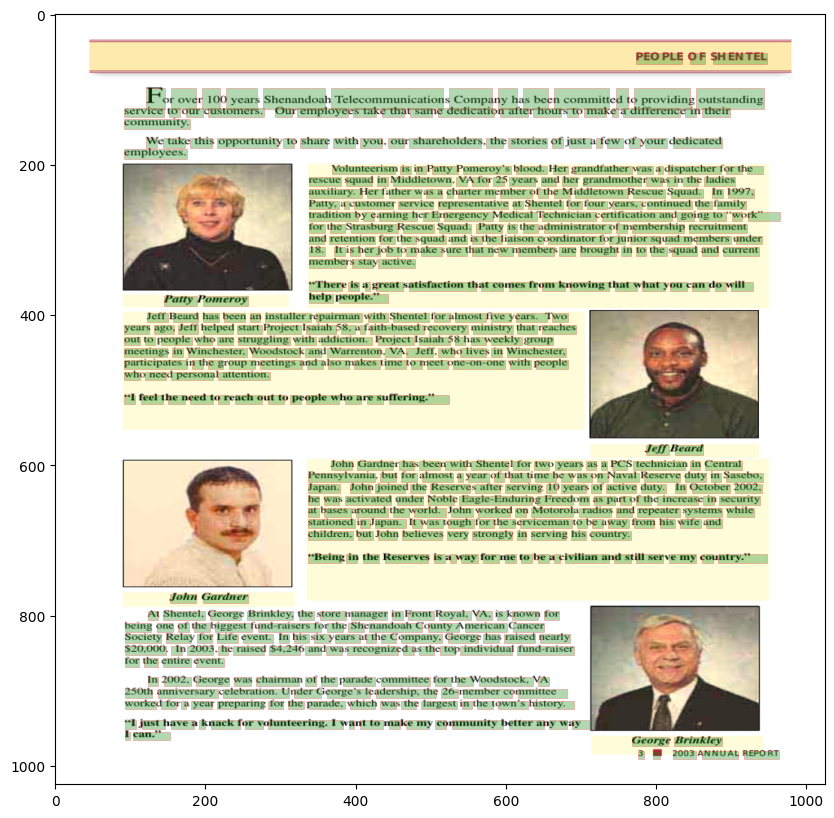

In [19]:
import random
from PIL import Image
import matplotlib.pyplot as plt
x = len(dataset)
random_idx = random.randint(0, x)
sample = dataset[random_idx]
image = sample['image']
import numpy as np
annoations = sample['ocr_boxes']
def plot_bounding_boxes(image,anno,figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    for ann in anno:
        box = ann
        rect = plt.Rectangle((box[0], box[1]), box[2], box[3], linewidth=0.5, edgecolor='r', facecolor='g',alpha=0.3)
        #add class name
        # ax.text(box[0], box[1], id2label[ann['category_id']]['name'], fontsize=12, color='red')
        ax.add_patch(rect)
    plt.show()
plot_bounding_boxes(image,annoations)

In [2]:
dataset[0]['ocr_words']

['Leigh',
 'Taliaferro,',
 'M.D.,',
 'values',
 'consistency.',
 'The',
 'Abilene',
 'native',
 'started',
 'his',
 'practice',
 '17',
 'years',
 'ago',
 'and',
 'has',
 'developed',
 'a',
 'flourishing',
 'business',
 'as',
 'a',
 'general',
 'surgeon.',
 'He',
 'estimates',
 'that',
 '90',
 'percent',
 'of',
 'his',
 'practice',
 'is',
 'for',
 'abdominal',
 'surgery.',
 'With',
 'such',
 'a',
 'busy',
 'practice,',
 'he',
 'finds',
 'comfort',
 'in',
 'having',
 'a',
 'reliable',
 'banking',
 'partner.',
 '“I',
 'have',
 'almost',
 'every',
 'type',
 'of',
 'busi-',
 'ness,',
 'trust',
 'and',
 'personal',
 'account',
 'with',
 'First',
 'National',
 'Bank',
 'of',
 'Abilene,”',
 'says',
 'Dr.',
 'Taliaferro.',
 '“First',
 'National',
 'is',
 'immersed',
 'in',
 'this',
 'city',
 '–',
 'everywhere',
 'you',
 'go,',
 'they',
 'are',
 'involved',
 'with',
 'helping',
 'people',
 'with',
 'their',
 'business.',
 'It’s',
 'because',
 'of',
 'the',
 'people',
 'who',
 'work',
 'there',
 

In [3]:
dataset[0]['ocr_boxes']

[[66.99346160888672,
  112.10344696044922,
  33.822017669677734,
  13.662796974182129],
 [107.57988739013672,
  112.10344696044922,
  74.40843963623047,
  13.662796974182129],
 [188.7527313232422,
  112.10344696044922,
  33.822017669677734,
  13.662796974182129],
 [229.3391571044922,
  112.10344696044922,
  40.586421966552734,
  13.662796974182129],
 [276.6899719238281,
  112.10344696044922,
  81.17284393310547,
  13.662796974182129],
 [66.99346160888672,
  133.58653259277344,
  18.743932723999023,
  13.534671783447266],
 [91.9853744506836, 133.58653259277344, 43.73583984375, 13.534671783447266],
 [141.9691925048828,
  133.58653259277344,
  37.48786544799805,
  13.534671783447266],
 [185.7050323486328, 133.58653259277344, 43.73583984375, 13.534671783447266],
 [235.68885803222656,
  133.58653259277344,
  18.743932723999023,
  13.534671783447266],
 [260.6807556152344,
  133.58653259277344,
  49.98381805419922,
  13.534671783447266],
 [316.9125671386719,
  133.58653259277344,
  12.4959545